# MNIST Digit Classification

In [1]:
# install required libraries 
%pip install -r ./requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import tensorflow and related libraries
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import random

# Force TensorFlow to use CPU only - MUST be set before importing tensorflow
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Reduce TensorFlow logging

# Check TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

# Check available devices
print("Available devices:")
for device in tf.config.list_physical_devices():
    print(f"  - {device}")
    
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")
print(f"Using device: {'GPU' if len(tf.config.list_physical_devices('GPU')) > 0 else 'CPU'}")

# Test CPU execution
test_tensor = tf.constant([1.0, 2.0, 3.0])
print(f"Test tensor device: {test_tensor.device}")
print("CPU-only configuration complete!")

2025-11-25 19:35:21.501750: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-25 19:35:21.658689: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-25 19:35:21.662033: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-25 19:35:23.888528: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


TensorFlow version: 2.12.0
Available devices:
  - PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
GPU Available: False
Using device: CPU
Test tensor device: /job:localhost/replica:0/task:0/device:CPU:0
CPU-only configuration complete!


## 1 MNIST dataset 

Download, load the dataset and display a few random samples from it:

In [3]:
# Load the MNIST dataset directly from tensorflow.keras.datasets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalize pixel values to [0, 1] range
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Print dataset information
print(f"Training data shape: {x_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Test labels shape: {y_test.shape}")

Training data shape: (60000, 28, 28)
Training labels shape: (60000,)
Test data shape: (10000, 28, 28)
Test labels shape: (10000,)


Our training set is made up of 28x28 grayscale images of handwritten digits.

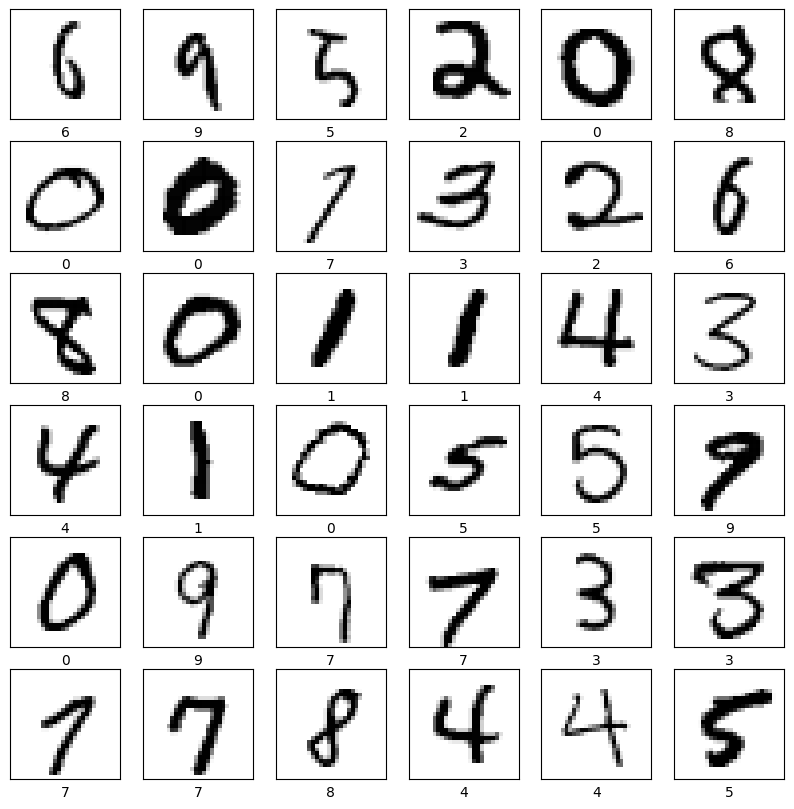

In [4]:
plt.figure(figsize=(10,10))
random_inds = np.random.choice(60000, 36)
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_ind = random_inds[i]
    plt.imshow(x_train[image_ind], cmap=plt.cm.binary)
    plt.xlabel(y_train[image_ind])

## 2 Neural Network for Handwritten Digit Classification

We'll first build a simple neural network consisting of two fully connected layers and apply this to the digit classification task. Our network will ultimately output a probability distribution over the 10 digit classes (0-9).


### 2.1 Fully connected neural network architecture

In [5]:
def create_fc_model():
    model = keras.Sequential([
        # first define a Flatten layer
        layers.Flatten(input_shape=(28, 28)),
        # define the first fully connected layer
        layers.Dense(128, activation='relu'),
        # define the second Dense layer to output the classification probabilities
        layers.Dense(10, activation='softmax')
    ])
    
    model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.1),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
    
    return model

model_fc = create_fc_model()
model_fc.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


Let's take a step back and think about the network we've just created. The first layer in this network, `layers.Flatten`, transforms the format of the images from a 2d-array (28 x 28 pixels), to a 1d-array of 28 * 28 = 784 pixels. You can think of this layer as unstacking rows of pixels in the image and lining them up. There are no learned parameters in this layer; it only reformats the data.

After the pixels are flattened, the network consists of a sequence of two `layers.Dense` layers. These are fully-connected neural layers. The first `Dense` layer has 128 nodes (or neurons) and uses ReLU activation. The second (and last) layer returns an array of probability scores using softmax activation. Each node contains a score that indicates the probability that the current image belongs to one of the handwritten digit classes.

That defines our fully connected model!

#### Train the model

Before training the model, we need to define a few more settings:

* *Loss function* — This defines how we measure how accurate the model is during training. During training we want to minimize this function, which will "steer" the model in the right direction.
* *Optimizer* — This defines how the model is updated based on the data it sees and its loss function.
* *Metrics* — Here we can define metrics used to monitor the training and testing steps. In this example, we'll look at the *accuracy*, the fraction of the images that are correctly classified.

We'll start out by using a stochastic gradient descent (SGD) optimizer initialized with a learning rate of 0.1. Since we are performing a categorical classification task, we'll want to use the [sparse categorical crossentropy loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses/sparse_categorical_crossentropy).

We're now ready to train our model, which will involve feeding the training data (`x_train` and `y_train`) into the model, and then asking it to learn the associations between images and labels. We'll also need to define the batch size and the number of epochs, or iterations over the MNIST dataset, to use during training.

In [6]:
# Train the model
history_fc = model_fc.fit(x_train, y_train,
                       batch_size=64,
                       epochs=5,
                       validation_split=0.2,
                       workers=-1, 
                       verbose=1)


Epoch 1/5
750/750 [==============================] - 6s 7ms/step - loss: 0.4078 - accuracy: 0.8879 - val_loss: 0.2376 - val_accuracy: 0.9345
Epoch 2/5
750/750 [==============================] - 5s 6ms/step - loss: 0.2174 - accuracy: 0.9374 - val_loss: 0.1825 - val_accuracy: 0.9490
Epoch 3/5
750/750 [==============================] - 5s 6ms/step - loss: 0.1652 - accuracy: 0.9523 - val_loss: 0.1509 - val_accuracy: 0.9572
Epoch 4/5
750/750 [==============================] - 5s 6ms/step - loss: 0.1340 - accuracy: 0.9619 - val_loss: 0.1335 - val_accuracy: 0.9624
Epoch 5/5
750/750 [==============================] - 5s 6ms/step - loss: 0.1127 - accuracy: 0.9686 - val_loss: 0.1198 - val_accuracy: 0.9655


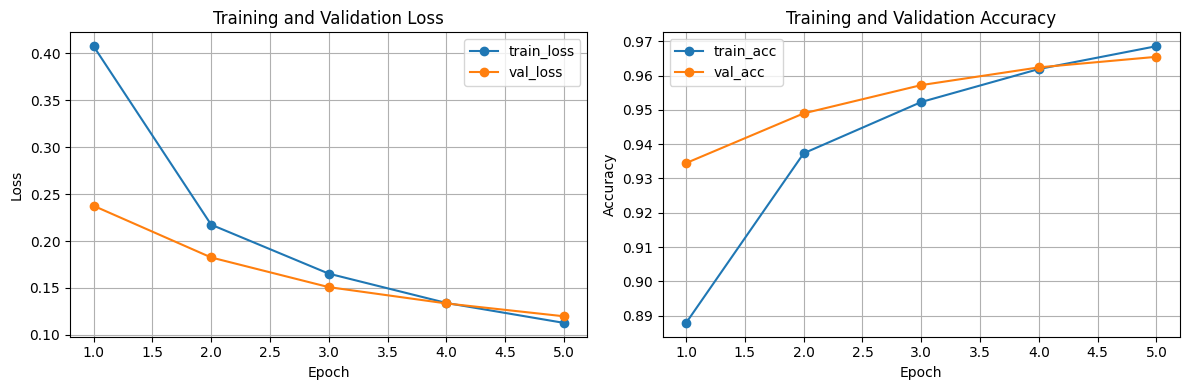

In [7]:
# define method to visualize the "history" callback i.e. record of training loss values and metrics
def visualize_history(history): 
    # Plot training history: loss and accuracy side-by-side
    # Use the history object returned by model.fit() (e.g. history_fc)
    hist = history.history
    epochs = range(1, len(next(iter(hist.values()))) + 1)
    plt.figure(figsize=(12,4))
    # Loss subplot
    plt.subplot(1,2,1)
    plt.plot(epochs, hist.get('loss', []), 'o-', label='train_loss')
    plt.plot(epochs, hist.get('val_loss', []), 'o-', label='val_loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    # Accuracy subplot (handle different key names)
    plt.subplot(1,2,2)
    acc_key = 'accuracy' if 'accuracy' in hist else ('acc' if 'acc' in hist else None)
    val_acc_key = 'val_' + acc_key if acc_key is not None else None
    if acc_key:
        plt.plot(epochs, hist.get(acc_key, []), 'o-', label='train_acc')
    if val_acc_key and val_acc_key in hist:
        plt.plot(epochs, hist.get(val_acc_key, []), 'o-', label='val_acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

visualize_history(history_fc)

In [8]:
# Final model
model_fc = create_fc_model()
history_fc = model_fc.fit(x_train, y_train,
                       batch_size=64,
                       epochs=4,
                       validation_split=0.2,
                       workers=-1, 
                       verbose=1)

Epoch 1/4
750/750 [==============================] - 5s 7ms/step - loss: 0.4094 - accuracy: 0.8860 - val_loss: 0.2413 - val_accuracy: 0.9317
Epoch 2/4
750/750 [==============================] - 5s 6ms/step - loss: 0.2224 - accuracy: 0.9363 - val_loss: 0.1924 - val_accuracy: 0.9473
Epoch 3/4
750/750 [==============================] - 5s 6ms/step - loss: 0.1712 - accuracy: 0.9513 - val_loss: 0.1554 - val_accuracy: 0.9565
Epoch 4/4
750/750 [==============================] - 5s 7ms/step - loss: 0.1390 - accuracy: 0.9602 - val_loss: 0.1368 - val_accuracy: 0.9612


As the model trains, the loss and accuracy metrics are displayed. With five epochs and a learning rate of 0.1, this fully connected model should achieve an accuracy of approximately 0.97 (or 97%) on the training data.

#### Evaluate accuracy on the test dataset

Now that we've trained the model, we can ask it to make predictions about a test set that it hasn't seen before. In this example, the `x_test` and `y_test` comprise our test dataset. To evaluate accuracy, we can check to see if the model's predictions match the labels from the test set.

In [9]:
# Evaluate the model on test data
test_loss, test_accuracy = model_fc.evaluate(x_test, y_test, verbose=0)

print(f"Test Error:")
print(f" Accuracy: {(100 * test_accuracy):>0.1f}%, Avg loss: {test_loss:>8f}")

# Optional: Get more detailed predictions
predictions = model_fc.predict(x_test, verbose=0)
predicted_classes = np.argmax(predictions, axis=1)

# Show some examples of correct and incorrect predictions
correct_predictions = predicted_classes == y_test
print(f"\nCorrect predictions: {np.sum(correct_predictions)}/{len(y_test)}")
print(f"Accuracy: {np.mean(correct_predictions)*100:.2f}%")

Test Error:
 Accuracy: 96.1%, Avg loss: 0.131981

Correct predictions: 9607/10000
Accuracy: 96.07%


### 2.2 Convolutional Neural Network (CNN) for handwritten digit classification

We will now build a CNN composed of two convolutional layers and pooling layers, followed by two fully connected layers, and ultimately output a probability distribution over the 10 digit classes (0-9). The CNN we will be building is depicted below:


#### Define the CNN model

We'll use the same training and test datasets as before, and proceed similarly as our fully connected network to define and train our new CNN model.

In [10]:
def create_cnn_model():
    model = keras.Sequential([
                    # First convolutional layer - note the input shape for the first layer
                    layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='same', 
                                activation='relu', input_shape=(28, 28, 1)),

                    # First max pooling layer
                    layers.MaxPooling2D(pool_size=2, strides=2),

                    # Second convolutional layer
                    layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', 
                                activation='relu'),

                    # Second max pooling layer
                    layers.MaxPooling2D(pool_size=2, strides=2),

                    # Flatten for the dense layers
                    layers.Flatten(),

                    # Fully connected layer
                    layers.Dense(128, activation='relu'),

                    # Output layer for classification (10 digits)
                    layers.Dense(10, activation='softmax')
                ])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),  # You can experiment (e.g., SGD, RMSprop)
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

    return model

# Display model architecture
model_cnn = create_cnn_model()
model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 3136)              0         
                                                                 
 dense_4 (Dense)             (None, 128)              

As was the case with the fully connected model, we can train our CNN using the training loop from above.

In [11]:
# Train the CNN model with the same batch_size and number of epochs
BATCH_SIZE = 64
EPOCHS = 10

# Prepare data for CNN - need to add channel dimension and reshape for TensorFlow
# TensorFlow expects (height, width, channels) format
x_train_cnn = x_train.reshape(-1, 28, 28, 1)  # Add channel dimension
x_test_cnn = x_test.reshape(-1, 28, 28, 1)   # Add channel dimension

# Force execution on CPU device
with tf.device('/CPU:0'):
    print("Training CNN on CPU device...")
    
    # Train the CNN model
    history_cnn = model_cnn.fit(x_train_cnn, y_train,
                               batch_size=BATCH_SIZE,
                               epochs=EPOCHS,
                               validation_split=0.1,  # Use 10% of training data for validation
                               verbose=1)
    
    print("CNN training completed on CPU!")

Training CNN on CPU device...
Epoch 1/10
844/844 [==============================] - 30s 34ms/step - loss: 0.1579 - accuracy: 0.9531 - val_loss: 0.0520 - val_accuracy: 0.9862
Epoch 2/10
844/844 [==============================] - 31s 36ms/step - loss: 0.0460 - accuracy: 0.9849 - val_loss: 0.0343 - val_accuracy: 0.9907
Epoch 3/10
844/844 [==============================] - 29s 34ms/step - loss: 0.0323 - accuracy: 0.9899 - val_loss: 0.0324 - val_accuracy: 0.9910
Epoch 4/10
844/844 [==============================] - 30s 35ms/step - loss: 0.0230 - accuracy: 0.9929 - val_loss: 0.0394 - val_accuracy: 0.9885
Epoch 5/10
844/844 [==============================] - 29s 34ms/step - loss: 0.0178 - accuracy: 0.9945 - val_loss: 0.0332 - val_accuracy: 0.9903
Epoch 6/10
844/844 [==============================] - 29s 34ms/step - loss: 0.0132 - accuracy: 0.9956 - val_loss: 0.0409 - val_accuracy: 0.9908
Epoch 7/10
844/844 [==============================] - 27s 32ms/step - loss: 0.0102 - accuracy: 0.9964 - va

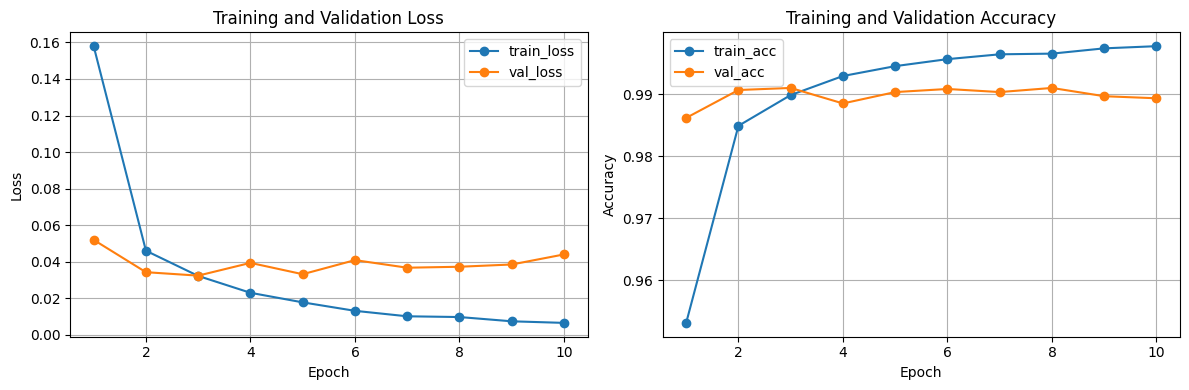

In [12]:
visualize_history(history_cnn)

In [13]:
model_cnn = create_cnn_model()
model_cnn.fit(x_train_cnn, y_train,
                           batch_size=BATCH_SIZE,
                           epochs=2,
                           validation_split=0.1,
                           verbose=1)

Epoch 1/2
844/844 [==============================] - 30s 33ms/step - loss: 0.1618 - accuracy: 0.9509 - val_loss: 0.0551 - val_accuracy: 0.9845
Epoch 2/2
844/844 [==============================] - 27s 32ms/step - loss: 0.0469 - accuracy: 0.9853 - val_loss: 0.0415 - val_accuracy: 0.9902


Great! Now that we've trained the model, let's evaluate it on the test dataset :

In [14]:
# Evaluate the CNN model on test data
with tf.device('/CPU:0'):
    test_loss_cnn, test_accuracy_cnn = model_cnn.evaluate(x_test_cnn, y_test, verbose=0)

    print(f"[CNN] Test Results:")
    print(f"  Accuracy: {(100 * test_accuracy_cnn):>0.1f}%")
    print(f"  Average Loss: {test_loss_cnn:>8f}")

    # Optional: Get more detailed predictions
    predictions_cnn = model_cnn.predict(x_test_cnn, verbose=0)
    predicted_classes_cnn = np.argmax(predictions_cnn, axis=1)

    # Show some examples of correct and incorrect predictions
    correct_predictions_cnn = predicted_classes_cnn == y_test
    print(f"\nCorrect predictions: {np.sum(correct_predictions_cnn)}/{len(y_test)}")
    print(f"CNN Test Accuracy: {np.mean(correct_predictions_cnn)*100:.2f}%")

[CNN] Test Results:
  Accuracy: 98.7%
  Average Loss: 0.038560

Correct predictions: 9873/10000
CNN Test Accuracy: 98.73%


## 3 Model saving and testing
Now that we have trained our CNN models, let's save it in the TensorFlow SavedModel format so it can be served using TensorFlow Serving in our Docker container.

In [15]:
# Create the directory structure for TensorFlow Serving
# Define the model save path according to TensorFlow Serving conventions
# The path structure should be: model_name/version_number/
model_fc_path = "./models/0/"
model_cnn_path = "./models/1/"

# Create the directory if it doesn't exist
os.makedirs(model_fc_path, exist_ok=True)
os.makedirs(model_cnn_path, exist_ok=True)

# Save the trained CNN model in SavedModel format for TensorFlow Serving
tf.saved_model.save(model_fc, model_fc_path)
tf.saved_model.save(model_cnn, model_cnn_path)

print(f"Model exported successfully at: {model_cnn_path}")

print("Directory structure:")
for root, dirs, files in os.walk("./models"):
    level = root.replace("./models", '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for file in files:
        print(f"{subindent}{file}")

INFO:tensorflow:Assets written to: ./models/0/assets


INFO:tensorflow:Assets written to: ./models/0/assets


INFO:tensorflow:Assets written to: ./models/1/assets


INFO:tensorflow:Assets written to: ./models/1/assets


Model exported successfully at: ./models/1/
Directory structure:
models/
  1/
    fingerprint.pb
    saved_model.pb
    variables/
      variables.data-00000-of-00001
      variables.index
    assets/
  0/
    fingerprint.pb
    saved_model.pb
    variables/
      variables.data-00000-of-00001
      variables.index
    assets/


### Test the saved model

Let's verify that our saved model works correctly by loading it and making a test prediction:

Original model prediction: 7
Loaded model prediction: 7
Actual label: 7
Predictions match: True


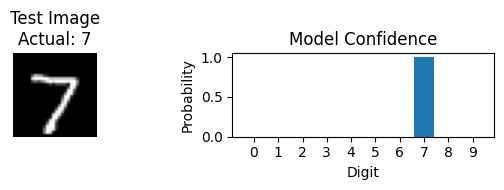

✅ Model saved and verified successfully!
SavedModel signatures: ['serving_default']
Output tensor name: dense_7


In [16]:
# Load the saved model to verify it works
# loaded_model = tf.saved_model.load(model_fc_path)
loaded_model = tf.saved_model.load(model_cnn_path)

# Get the inference function
infer = loaded_model.signatures["serving_default"]

# Test with a sample from the test set
test_image = x_test_cnn[0:1]  # Take the first test image
test_label = y_test[0]

# Make prediction with original model
original_prediction = model_cnn.predict(test_image, verbose=0)
original_class = np.argmax(original_prediction)

# Make prediction with loaded model (SavedModel format)
test_tensor = tf.convert_to_tensor(test_image, dtype=tf.float32)
loaded_prediction_dict = infer(test_tensor)

# Extract the prediction array 
loaded_prediction_key = list(loaded_prediction_dict.keys())[0]
loaded_prediction = loaded_prediction_dict[loaded_prediction_key].numpy()
loaded_class = np.argmax(loaded_prediction)

print(f"Original model prediction: {original_class}")
print(f"Loaded model prediction: {loaded_class}")
print(f"Actual label: {test_label}")
print(f"Predictions match: {original_class == loaded_class}")

# Display the test image
plt.figure(figsize=(6, 2))
plt.subplot(1, 2, 1)
plt.imshow(test_image[0].squeeze(), cmap='gray')
plt.title(f'Test Image\nActual: {test_label}')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.bar(range(10), loaded_prediction[0])
plt.title('Model Confidence')
plt.xlabel('Digit')
plt.ylabel('Probability')
plt.xticks(range(10))
plt.tight_layout()
plt.show()

print("✅ Model saved and verified successfully!")
print(f"SavedModel signatures: {list(loaded_model.signatures.keys())}")
print(f"Output tensor name: {loaded_prediction_key}")

In [17]:
# Save test_image as a JSON payload for TensorFlow Serving
# import json
# import numpy as np
# # test_image is shape (1, H, W, C) - convert to list of lists
# arr = test_image.astype('float32')
# # Ensure values are in [0,1] as in training
# # If saved image was 0-255, normalize here; in our notebook test_image was normalized already
# payload = {'instances': arr.tolist()}
# with open('test.json','w') as f:
#     json.dump(payload, f)
# print('Wrote test.json with instances shape:', np.array(payload['instances']).shape)